In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from pyspark.sql.window import Window
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
import pandas as pd
spark = SparkSession.builder \
    .appName("Analysis on 3w") \
    .getOrCreate()

In [51]:
df= (
    spark.read.csv(
        "../dataset/dataset_final.csv", 
        header=True,
        inferSchema=True
    )
    .withColumn("Exporsure_cat",
                f.when(f.col("Exposure")<50,"Below_50%")
                .when(f.col("Exposure").between(50,60),"50-60%")
                .when(f.col("Exposure").between(60,70),"60-70%")
                .when(f.col("Exposure").between(70,80),"70-80%")
                .otherwise("above_80%") 
               )
    .withColumn('DCSR_cat',
               f.when(f.col("DSCR")>1.5,"Above_1.5_times")
               .when(f.col("DSCR").between(1.25,1.5),"1.25-1.5times")
               .when(f.col("DSCR").between(1,1.25),"1-1.25 times")
               .otherwise("Income<Commitments"))
    .withColumn('DCSR_cat',
               f.when(f.col("DSCR")>1.5,"Above_1.5_times")
               .when(f.col("DSCR").between(1.25,1.5),"1.25-1.5times")
               .when(f.col("DSCR").between(1,1.25),"1-1.25 times")
               .otherwise("Income<Commitments"))
    .withColumn('CRIB_SC',
                f.when(f.col("CRIB_SC"))
    )
)

In [52]:
df=df.toPandas()

In [53]:
df.head(20)

,FACNO,CRIB,CRIB_SC,Product,Product_overall_score,Client_PreNises,CUST_PERMRES_SCORE,Guarantor_PreNises,Guarantor_PreNises_Over_All_score,Exposure,Exposure_Category(Score),DSCR,DCSR_over_all_score,DPD,Final_Score,New_Decision,good/bad,Exporsure_cat,DCSR_cat
0,4.200000e+15,HIT,-107.5,Cash in Hand,15,With Parents/Spouse,15,With Parents/Spouse,8,22.01,25,2.4200184,5,0,41.125,Red,good,Below_50%,Above_1.5_times
1,2.800000e+15,HIT,-400,Registered 3W,15,0,0,0,0,0,25,0,-80,0,-65.195,Red,good,Below_50%,Income<Commitments
2,1.100000e+15,HIT,-400,Registered 3W,15,With Billing Proof,20,With Billing Proof,10,93.02,-80,2.3212628,5,45,-53.065,Red,good,above_80%,Above_1.5_times
3,1.060000e+16,HIT,-18.14,Registered 3W,15,With Billing Proof,20,With Billing Proof,10,57.16,20,1.397502,3,0,46.1375,Red,good,50-60%,1.25-1.5times
4,8.200000e+15,HIT,-400,Registered 3W,15,With Billing Proof,20,With Billing Proof,10,68.95,15,3.2241164,5,5,43.25,Red,good,60-70%,Above_1.5_times
5,6.700000e+15,HIT,-87,Registered 3W,15,With Billing Proof,20,With Billing Proof,10,45.17,25,4.3039549,5,0,53.25,Red,good,Below_50%,Above_1.5_times
6,1.550000e+16,HIT,-400,Registered 3W,15,With G S Certificate,10,Rent,2,61.67,15,3.7553648,5,5,25.25,Red,good,60-70%,Above_1.5_times
7,1.640000e+16,HIT,-400,Registered 3W,15,With Billing Proof,20,With Billing Proof,10,55.1,20,3.148086,5,82,48.345,Red,good,50-60%,Above_1.5_times
8,8.600000e+15,HIT,-400,Registered 3W,15,0,0,0,0,0,25,0,-80,229,-61.115,Red,bad,Below_50%,Income<Commitments
9,5.800000e+15,HIT,-400,Registered 3W,15,0,0,0,0,0,25,0,-80,10,-60.8225,Red,good,Below_50%,Income<Commitments


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9340 entries, 0 to 9339
Data columns (total 19 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   FACNO                              9340 non-null   float64
 1   CRIB                               9340 non-null   object 
 2   CRIB_SC                            9340 non-null   object 
 3   Product                            9340 non-null   object 
 4   Product_overall_score              9340 non-null   object 
 5   Client_PreNises                    9340 non-null   object 
 6   CUST_PERMRES_SCORE                 9340 non-null   int32  
 7   Guarantor_PreNises                 9296 non-null   object 
 8   Guarantor_PreNises_Over_All_score  9340 non-null   int32  
 9   Exposure                           9335 non-null   object 
 10  Exposure_Category(Score)           9340 non-null   object 
 11  DSCR                               9340 non-null   objec

In [59]:
df_cat=df[["CRIB","Product","DCSR_cat","Client_PreNises","Exporsure_cat","Guarantor_PreNises","good/bad"]]
for col in df_cat.columns:
    le = LabelEncoder()
    df_cat[col] = le.fit_transform(df_cat[col])

C:\Users\pamith.rathnayake\AppData\Local\Temp\ipykernel_7920\3018522171.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cat[col] = le.fit_transform(df_cat[col])
C:\Users\pamith.rathnayake\AppData\Local\Temp\ipykernel_7920\3018522171.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cat[col] = le.fit_transform(df_cat[col])
C:\Users\pamith.rathnayake\AppData\Local\Temp\ipykernel_7920\3018522171.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

In [60]:
df_cat.head()

,CRIB,Product,DCSR_cat,Client_PreNises,Exporsure_cat,Guarantor_PreNises,good/bad
0,0,1,2,5,3,6,1
1,0,2,3,1,3,1,1
2,0,2,2,3,4,4,1
3,0,2,1,3,0,4,1
4,0,2,2,3,1,4,1


In [61]:
X=df_cat.drop(columns=['good/bad'],axis=1)
y=df_cat["good/bad"]

In [62]:
chi_score= chi2(X,y)

In [48]:
chi_score

(array([  0.42172108,  15.75112679,   1.2182818 ,   0.68563065,
        100.04050158,   0.44260297]),
 array([5.16079507e-01, 7.22448948e-05, 2.69698113e-01, 4.07654548e-01,
        1.49312281e-23, 5.05868780e-01]))

<Axes: >

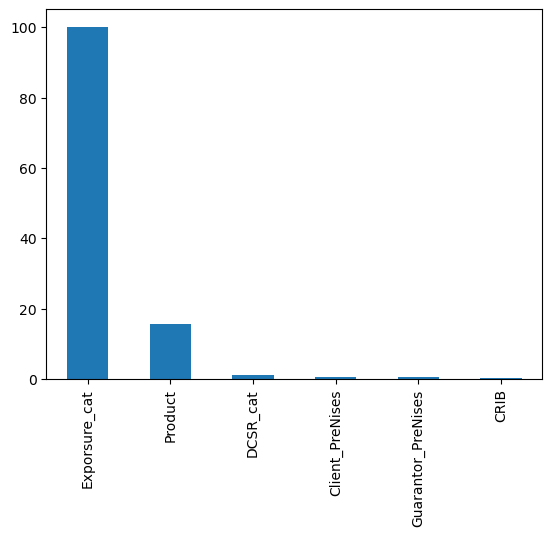

In [49]:
chi_values = pd.Series(chi_score[0], index=X.columns)
chi_values.sort_values(ascending= False, inplace=True)
chi_values.plot.bar()